In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from dataset import DataSet,ZtfDataSet
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest as IF
%load_ext autoreload
np.random.seed(2) ## keep same shuffled as was trained on 
torch.manual_seed(2)

In [345]:
%autoreload

In [349]:
seed=2
folder = '../../datasets/ZTF_gri'
min_length=25
sep=','
start_col=1
keep_missing=False
np.random.seed(seed=seed) 
torch.manual_seed(seed=seed)
lcs_stats = ZtfDataSet(folder)
lcs_stats.files_to_df()
lcs_stats.read(sep=sep)
lcs_stats.prune(min_length=min_length, start_col=start_col, keep_missing=keep_missing)
lcs_stats.set_mean_mag()
lcs_stats.set_sigma_xs()
lcs_stats.set_med_cadence()

found 3408 for band='r'
found 3408 for band='i'
found 3408 for band='g'


## load a checkpoint & dataset the network trained on

In [7]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_g0.668415367603302.h5', lcs.data_obj)


TypeError: cannot unpack non-iterable NoneType object

In [17]:
# encode full dataset
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net)
#qzs_sub, disc_path_sub = utils.encode(lcs.data_obj['train_loader'], net, device='mps', subsample=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:17<00:00, 71.55it/s]


In [22]:
print(qzs.shape, disc_path.shape)

(2559, 2, 16, 64) (2559, 16, 64)


In [23]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)
tr = int(l * 0.9) # train-test split point

## Sample qZ

In [24]:
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

### uncomment USE MEAN OF QZ instead
# zs = qzs[:,0,:,:].reshape(qzs.shape[0],-1)

In [373]:
lcs = utils.get_data('../../datasets/ZTF_gri',min_length=0, keep_missing=True)

found 3408 for band='r'
found 3408 for band='i'
found 3408 for band='g'


/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/dataset.py:167: RuntimeWarning: divide by zero encountered in true_divide
  lc[:,2] = lc[:,2] / np.std(lc[:,1])


max time:  1687.1758
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(3177, 3, 4396, 3)
train size: 2859, valid size: 572, test size: 318


In [375]:
s = 0

for i in range(3177):
    for j in range(3):
        if lcs.dataset[i,j,:,1].any():
            s+=1
    

In [376]:
s

8823

In [50]:
zs = np.loadtxt('../pca_grid_exps/zs_gri.dat')

In [3]:
RS = 20150101
pca = PCA(random_state=RS)

### pcall

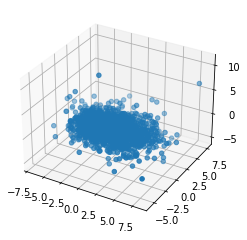

In [51]:
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])

In [27]:
y = [  26,   73,   75,  100,  115,  132,  135,  217,  233,  267,  270,
        332,  384,  395,  396,  415,  478,  523,  772,  911,  927,  932,
       1006, 1007, 1052, 1067, 1071, 1101, 1105, 1112, 1210, 1296, 1459,
       1516]
z = [ 722,  770,  840,  913, 1028, 1124, 1294]

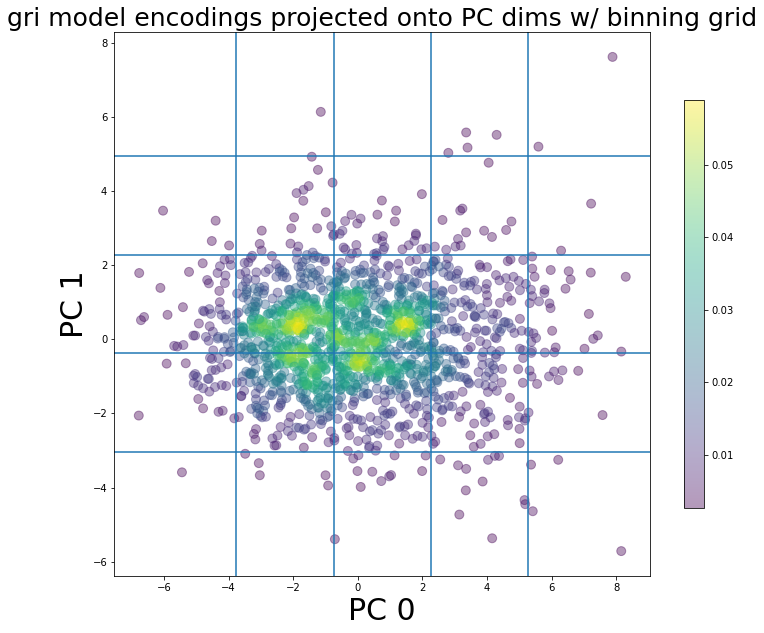

In [71]:
pl = pca3d[:,0:2].T
k = gaussian_kde(pl, bw_method=0.1)(pl)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
dens = ax.scatter(pca3d[:,0],pca3d[:,1],c=k, alpha=0.4,s=80)
# ax.scatter(pca3d[z,0],pca3d[z,1],c='red', alpha=0.4,s=80)
ax.set_xlabel('PC 0',fontsize=30)
ax.set_ylabel('PC 1', fontsize=30)

PC0_bins = [ -3.76896034, -0.75188821,  2.26518393,  5.28225607]
PC1_bins = [ -3.04821428, -0.38112785,  2.28595859,  4.95304502]
for hline in PC1_bins:
    ax.axhline(hline)
for vline in PC0_bins:
    ax.axvline(vline)
fig.colorbar(dens,shrink=0.75)
ax.set_title('gri model encodings projected onto PC dims w/ binning grid',fontsize=25)
plt.savefig('../img/anomaly_d/pca2d_bingrid.pdf')

# make grid from reconstructions 

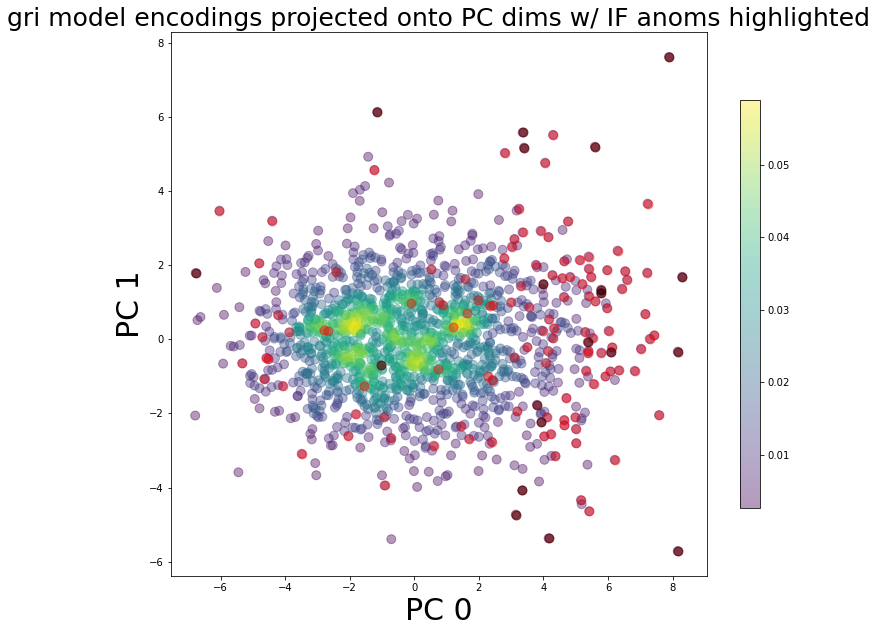

In [70]:
pl = pca3d[:,0:2].T
k = gaussian_kde(pl, bw_method=0.1)(pl)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
dens = ax.scatter(pca3d[:,0],pca3d[:,1],c=k, alpha=0.4,s=80)
ax.scatter(pca3d[x,0],pca3d[x,1],c='red', alpha=0.4,s=80)
ax.scatter(pca3d[y,0],pca3d[y,1],c='black', alpha=0.4,s=80)
ax.set_xlabel('PC 0',fontsize=30)
ax.set_ylabel('PC 1', fontsize=30)

# PC0_bins = [ -3.76896034, -0.75188821,  2.26518393,  5.28225607]
# PC1_bins = [ -3.04821428, -0.38112785,  2.28595859,  4.95304502]
# for hline in PC1_bins:
#     ax.axhline(hline)
# for vline in PC0_bins:
#     ax.axvline(vline)
fig.colorbar(dens,shrink=0.75)
ax.set_title('gri model encodings projected onto PC dims w/ IF anoms highlighted',fontsize=25)
plt.savefig('../img/anomaly_d/pca2d_anom.pdf')

# make grid from reconstructions 

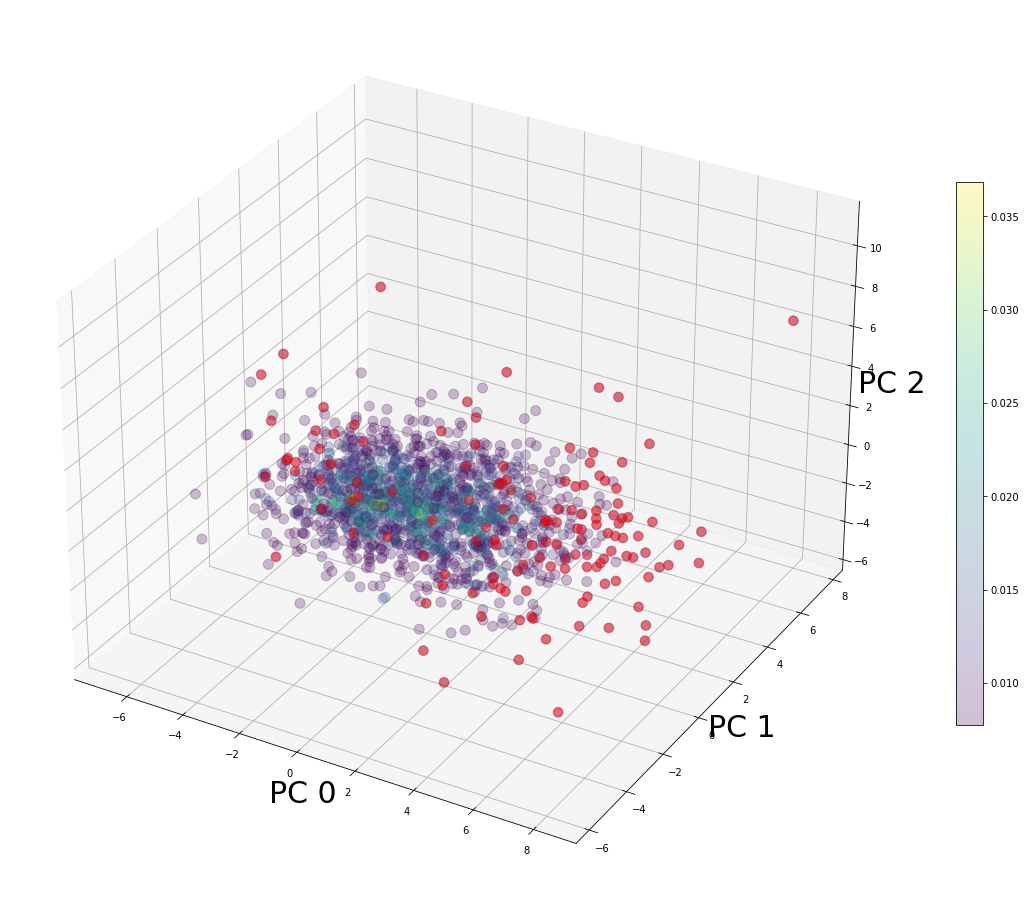

In [22]:
pl = pca3d[:,0:3].T
k = gaussian_kde(pl, bw_method=0.1)(pl)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
dens = ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2],c=k, alpha=0.25,s=100)
ax.scatter(pca3d[x,0],pca3d[x,1],pca3d[x,2],c='red', alpha=0.4,s=80)
ax.set_xlabel('PC 0',fontsize=30)
ax.set_ylabel('PC 1', fontsize=30)
ax.set_zlabel('PC 2', fontsize=30)
fig.colorbar(dens,shrink=0.5)
# plt.savefig('../img/pca3d')

## Anonymous Recon

In [9]:
## avg over 10 different fraction subsamples
avg_nlls = np.zeros((10,len(lcs.dataset)))
for i in range(10):
    _,_,nlls = utils.evaluate_hetvae(net, 1, lcs.data_obj['train_loader'], frac=0.5, device='mps', qz_mean=True)
    np.savetxt(f'./nlls_g/nlls_g_{i}',nlls)
    avg_nlls[i] = nlls
    
#avg_nlls = nlls.mean(0)
# std = np.std(nlls)
# mu = np.mean(nlls)
# anom_nlls = (nlls>mu+std) | (nlls<mu-std)


  0%|▋                                                                                                                                                         | 6/1280 [00:19<1:08:55,  3.25s/it]

KeyboardInterrupt



In [14]:
zs.shape

(1527, 1024)

In [150]:
bins01_pca = [ 170,  199,  233,  272,  356,  377,  458,  467,  483,  499,  560,
        577,  657,  692,  749,  765,  965,  974,  992, 1012, 1078, 1136,
       1151, 1408, 3,   10,   25,   40,   42,   44,   46,   54,   71,   73,   74,
         75,   87,  102,  121,  128,  139,  150,  166,  182,  192,  197,
        232,  239,  243,  259,  285,  288,  296,  303,  322,  327,  328,
        337,  338,  341,  355,  362,  364,  368,  369,  372,  376,  379,
        389,  394,  399,  401,  407,  413,  417,  440,  453,  457,  488,
        491,  496,  504,  513,  521,  531,  550,  552,  561,  568,  570,
        571,  579,  580,  582,  590,  591,  601,  611,  628,  629,  630,
        639,  670,  688,  698,  699,  714,  720,  726,  738,  742,  752,
        772,  777,  786,  789,  793,  796,  799,  806,  820,  831,  842,
        861,  863,  864,  866,  885,  886,  908,  925,  939,  940,  949,
        961,  969,  972,  979,  981,  997, 1010, 1016, 1025, 1027, 1034,
       1040, 1047, 1049, 1055, 1059, 1077, 1081, 1084, 1108, 1125, 1126,
       1127, 1131, 1157, 1161, 1168, 1181, 1196, 1202, 1206, 1207, 1217,
       1238, 1243, 1258, 1270, 1278, 1279, 1297, 1301, 1332, 1342, 1363,
       1377, 1395, 1412, 1424, 1453, 1483, 1500, 1514]
bin0 = [ 170,  199,  233,  272,  356,  377,  458,  467,  483,  499,  560,
        577,  657,  692,  749,  765,  965,  974,  992, 1012, 1078, 1136,
       1151, 1408]
bin7 = [  18,  220,  260,  384,  411,  586,  651,  770,  853,  867,  917,
       1019, 1173, 1175, 1485]
bin1 = [   3,   10,   25,   40,   42,   44,   46,   54,   71,   73,   74,
         75,   87,  102,  121,  128,  139,  150,  166,  182,  192,  197,
        232,  239,  243,  259,  285,  288,  296,  303,  322,  327,  328,
        337,  338,  341,  355,  362,  364,  368,  369,  372,  376,  379,
        389,  394,  399,  401,  407,  413,  417,  440,  453,  457,  488,
        491,  496,  504,  513,  521,  531,  550,  552,  561,  568,  570,
        571,  579,  580,  582,  590,  591,  601,  611,  628,  629,  630,
        639,  670,  688,  698,  699,  714,  720,  726,  738,  742,  752,
        772,  777,  786,  789,  793,  796,  799,  806,  820,  831,  842,
        861,  863,  864,  866,  885,  886,  908,  925,  939,  940,  949,
        961,  969,  972,  979,  981,  997, 1010, 1016, 1025, 1027, 1034,
       1040, 1047, 1049, 1055, 1059, 1077, 1081, 1084, 1108, 1125, 1126,
       1127, 1131, 1157, 1161, 1168, 1181, 1196, 1202, 1206, 1207, 1217,
       1238, 1243, 1258, 1270, 1278, 1279, 1297, 1301, 1332, 1342, 1363,
       1377, 1395, 1412, 1424, 1453, 1483, 1500, 1514]
bin2 =  [ 0,    4,   12,   14,   15,   19,   24,   27,   28,   33,   34,
         39,   50,   57,   59,   60,   61,   79,   85,   86,   90,   98,
        101,  103,  110,  112,  120,  127,  131,  136,  146,  151,  158,
        161,  162,  164,  165,  172,  176,  178,  183,  196,  201,  205,
        213,  215,  216,  218,  221,  225,  228,  229,  234,  236,  240,
        242,  247,  249,  250,  251,  252,  254,  255,  258,  269,  274,
        276,  279,  289,  290,  294,  295,  297,  305,  306,  307,  310,
        311,  316,  317,  324,  329,  334,  335,  336,  347,  348,  354,
        357,  365,  373,  378,  387,  392,  403,  404,  423,  443,  446,
        450,  459,  463,  465,  466,  471,  473,  475,  479,  480,  487,
        494,  500,  506,  508,  510,  512,  514,  516,  522,  526,  540,
        542,  545,  547,  564,  565,  569,  574,  575,  589,  596,  599,
        606,  608,  617,  626,  627,  634,  635,  636,  637,  640,  641,
        642,  643,  648,  649,  654,  656,  659,  660,  669,  675,  677,
        681,  682,  700,  701,  705,  706,  707,  713,  718,  728,  730,
        731,  734,  735,  739,  743,  744,  750,  751,  753,  758,  759,
        761,  768,  775,  778,  779,  785,  787,  790,  800,  805,  807,
        812,  822,  823,  824,  828,  833,  838,  845,  847,  854,  862,
        868,  871,  872,  874,  875,  884,  895,  899,  902,  903,  906,
        919,  920,  921,  922,  923,  930,  931,  933,  935,  937,  941,
        945,  946,  947,  952,  955,  956,  957,  966,  967,  971,  977,
        983,  987,  988,  989,  990,  995,  999, 1002, 1005, 1008, 1009,
       1021, 1023, 1024, 1028, 1029, 1035, 1039, 1043, 1045, 1050, 1057,
       1062, 1070, 1074, 1086, 1088, 1095, 1096, 1107, 1113, 1116, 1119,
       1120, 1122, 1128, 1137, 1139, 1140, 1143, 1145, 1147, 1148, 1158,
       1162, 1170, 1180, 1182, 1185, 1186, 1187, 1188, 1189, 1191, 1192,
       1197, 1203, 1211, 1216, 1220, 1221, 1229, 1230, 1232, 1233, 1241,
       1242, 1248, 1252, 1260, 1261, 1269, 1275, 1277, 1282, 1283, 1284,
       1287, 1292, 1295, 1298, 1299, 1306, 1309, 1311, 1312, 1326, 1327,
       1330, 1336, 1340, 1343, 1345, 1348, 1351, 1352, 1353, 1355, 1357,
       1364, 1366, 1367, 1368, 1370, 1374, 1375, 1382, 1389, 1390, 1391,
       1392, 1396, 1405, 1409, 1410, 1411, 1413, 1425, 1427, 1431, 1433,
       1435, 1438, 1439, 1443, 1444, 1450, 1455, 1456, 1458, 1467, 1468,
       1473, 1475, 1478, 1480, 1486, 1487, 1489, 1491, 1495, 1501, 1503,
       1505, 1506, 1508, 1510, 1515, 1519, 1526]

bin6 = [  20,   36,   45,   58,   77,   99,  106,  155,  217,  223,  226,
        293,  309,  319,  371,  380,  381,  393,  395,  426,  427,  432,
        474,  525,  527,  556,  587,  588,  616,  624,  667,  685,  722,
        741,  747,  762,  794,  798,  802,  815,  816,  834,  850,  870,
        876,  882,  890,  896,  914,  918,  929,  996, 1007, 1052, 1056,
       1083, 1101, 1104, 1135, 1153, 1156, 1164, 1167, 1177, 1195, 1257,
       1280, 1319, 1426, 1497]
bin5 = [   5,    8,    9,   21,   29,   41,   43,   47,   48,   53,   55,
         56,   92,  100,  108,  118,  125,  133,  135,  137,  141,  152,
        163,  179,  184,  191,  200,  209,  210,  224,  246,  248,  256,
        275,  299,  326,  331,  332,  344,  349,  351,  353,  359,  367,
        388,  397,  415,  420,  424,  431,  433,  434,  436,  441,  448,
        468,  469,  481,  490,  493,  495,  503,  505,  515,  519,  532,
        535,  536,  537,  538,  553,  555,  559,  572,  598,  605,  609,
        620,  625,  633,  655,  665,  671,  686,  689,  695,  724,  727,
        733,  754,  755,  757,  760,  766,  797,  801,  819,  835,  840,
        848,  852,  892,  901,  911,  913,  916,  932,  938,  944,  958,
        975,  982,  991,  998, 1015, 1020, 1022, 1031, 1060, 1067, 1076,
       1090, 1118, 1124, 1138, 1141, 1159, 1163, 1165, 1193, 1198, 1201,
       1210, 1212, 1250, 1281, 1286, 1294, 1331, 1337, 1354, 1356, 1360,
       1387, 1394, 1399, 1418, 1423, 1476, 1494, 1511, 1516, 1517, 1521,
       1524]
bin4 = [   2,   16,   23,   26,   37,   62,   64,   66,   68,   78,   80,
         81,   82,   83,   97,  111,  114,  117,  119,  123,  126,  130,
        138,  142,  143,  145,  147,  148,  149,  154,  156,  159,  168,
        169,  174,  175,  177,  180,  181,  185,  187,  188,  194,  198,
        204,  208,  211,  214,  230,  235,  237,  238,  241,  270,  271,
        273,  282,  286,  292,  298,  300,  304,  308,  323,  325,  330,
        342,  343,  345,  360,  361,  363,  366,  370,  374,  382,  383,
        386,  390,  400,  416,  418,  419,  421,  422,  430,  435,  437,
        445,  456,  460,  462,  470,  472,  477,  478,  484,  485,  486,
        492,  497,  498,  501,  511,  517,  518,  520,  523,  524,  529,
        541,  543,  544,  557,  558,  563,  581,  585,  600,  603,  604,
        607,  612,  613,  615,  618,  619,  631,  638,  644,  645,  650,
        661,  666,  668,  672,  680,  683,  690,  693,  702,  703,  709,
        710,  715,  716,  729,  732,  740,  763,  767,  769,  776,  781,
        783,  784,  804,  808,  811,  814,  817,  821,  826,  827,  829,
        830,  832,  837,  839,  849,  851,  855,  856,  857,  858,  859,
        869,  873,  877,  879,  880,  883,  887,  889,  898,  909,  912,
        915,  924,  926,  936,  942,  948,  951,  953,  954,  970,  978,
        993, 1003, 1004, 1006, 1011, 1017, 1018, 1030, 1033, 1036, 1042,
       1051, 1054, 1064, 1068, 1069, 1075, 1082, 1089, 1091, 1092, 1093,
       1098, 1103, 1106, 1111, 1115, 1121, 1130, 1134, 1142, 1146, 1149,
       1150, 1152, 1171, 1174, 1184, 1194, 1199, 1200, 1204, 1205, 1208,
       1214, 1215, 1218, 1222, 1226, 1228, 1231, 1234, 1239, 1245, 1246,
       1255, 1262, 1263, 1264, 1265, 1271, 1272, 1276, 1285, 1288, 1289,
       1293, 1296, 1302, 1305, 1310, 1314, 1315, 1316, 1321, 1324, 1325,
       1329, 1334, 1338, 1347, 1349, 1350, 1358, 1359, 1362, 1372, 1381,
       1383, 1384, 1386, 1393, 1398, 1400, 1414, 1415, 1417, 1420, 1421,
       1429, 1432, 1437, 1440, 1441, 1446, 1449, 1452, 1454, 1460, 1462,
       1465, 1470, 1472, 1477, 1479, 1481, 1482, 1493, 1502, 1509, 1512,
       1513, 1525]
bin3 = [   1,    6,    7,   11,   13,   17,   22,   30,   31,   32,   35,
         38,   49,   51,   52,   63,   65,   67,   69,   70,   72,   76,
         84,   88,   89,   91,   93,   94,   95,   96,  104,  105,  107,
        109,  113,  115,  116,  122,  124,  129,  132,  134,  140,  144,
        153,  157,  160,  167,  171,  173,  186,  189,  190,  193,  195,
        202,  203,  206,  207,  212,  219,  222,  227,  231,  244,  245,
        253,  257,  261,  262,  263,  264,  265,  266,  267,  268,  277,
        278,  280,  281,  283,  284,  287,  291,  301,  302,  312,  313,
        314,  315,  318,  320,  321,  333,  339,  340,  346,  350,  352,
        358,  375,  385,  391,  396,  398,  402,  405,  406,  408,  409,
        410,  412,  414,  425,  428,  429,  438,  439,  442,  444,  447,
        449,  451,  452,  454,  455,  461,  464,  476,  482,  489,  502,
        507,  509,  528,  530,  533,  534,  539,  546,  548,  549,  551,
        554,  562,  566,  567,  573,  576,  578,  583,  584,  592,  593,
        594,  595,  597,  602,  610,  614,  621,  622,  623,  632,  646,
        647,  652,  653,  658,  662,  663,  664,  673,  674,  676,  678,
        679,  684,  687,  691,  694,  696,  697,  704,  708,  711,  712,
        717,  719,  721,  723,  725,  736,  737,  745,  746,  748,  756,
        764,  771,  773,  774,  780,  782,  788,  791,  792,  795,  803,
        809,  810,  813,  818,  825,  836,  841,  843,  844,  846,  860,
        865,  878,  881,  888,  891,  893,  894,  897,  900,  904,  905,
        907,  910,  927,  928,  934,  943,  950,  959,  960,  962,  963,
        964,  968,  973,  976,  980,  984,  985,  986,  994, 1000, 1001,
       1013, 1014, 1026, 1032, 1037, 1038, 1041, 1044, 1046, 1048, 1053,
       1058, 1061, 1063, 1065, 1066, 1071, 1072, 1073, 1079, 1080, 1085,
       1087, 1094, 1097, 1099, 1100, 1102, 1105, 1109, 1110, 1112, 1114,
       1117, 1123, 1129, 1132, 1133, 1144, 1154, 1155, 1160, 1166, 1169,
       1172, 1176, 1178, 1179, 1183, 1190, 1209, 1213, 1219, 1223, 1224,
       1225, 1227, 1235, 1236, 1237, 1240, 1244, 1247, 1249, 1251, 1253,
       1254, 1256, 1259, 1266, 1267, 1268, 1273, 1274, 1290, 1291, 1300,
       1303, 1304, 1307, 1308, 1313, 1317, 1318, 1320, 1322, 1323, 1328,
       1333, 1335, 1339, 1341, 1344, 1346, 1361, 1365, 1369, 1371, 1373,
       1376, 1378, 1379, 1380, 1385, 1388, 1397, 1401, 1402, 1403, 1404,
       1406, 1407, 1416, 1419, 1422, 1428, 1430, 1434, 1436, 1442, 1445,
       1447, 1448, 1451, 1457, 1459, 1461, 1463, 1464, 1466, 1469, 1471,
       1474, 1484, 1488, 1490, 1492, 1496, 1498, 1499, 1504, 1507, 1518,
       1520, 1522, 1523]

In [151]:
scores[bin0].mean(), scores[bin1].mean(), scores[bin2].mean(),scores[bin3].mean(),scores[bin4].mean(),scores[bin5].mean(),scores[bin6].mean(),scores[bin7].mean()

(-0.444846615770427,
 -0.4392116129558533,
 -0.4355251414211894,
 -0.4350519964207234,
 -0.4371981898217154,
 -0.4447016925149261,
 -0.4527625866166083,
 -0.46515768597417356)

In [152]:
len(bin0) + len(bin1)

186

In [149]:
scores[bin6].mean(), scores[bin7].mean()

(-0.4527625866166083, -0.46515768597417356)

In [144]:
scores[bin0].mean()

-0.444846615770427

In [138]:
len(bins01_pca)

186

In [141]:
scores[bins01_pca].mean()

-0.4399387100932176

# Isolation Forest

In [6]:
latent = zs.reshape(zs.shape[0],-1) # flatten z

forest = IF(random_state=RS, n_estimators=500,contamination=0.02)
forest.fit(latent)
scores = forest.score_samples(latent)
anom_if_preds = forest.predict(latent)


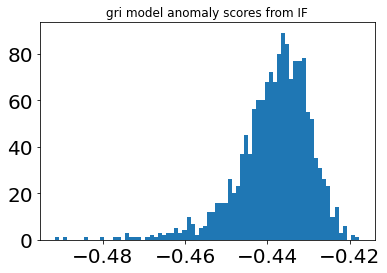

In [104]:
plt.hist(scores,bins=np.arange(np.min(scores),np.max(scores),0.001))
plt.title('gri model anomaly scores from IF')
plt.savefig('../img/anomaly_d/gri_if_scores')

In [55]:
x = np.where(scores <= -0.45)[0]
len(x)

135

In [56]:
y = np.where(scores <= -0.465)[0]
len(y)

20

In [8]:
x

array([  77,  135,  293,  384,  411,  415,  438,  458,  469,  519,  525,
        609,  722,  770,  840,  867,  876,  932, 1028, 1124])

In [371]:
np.set_printoptions(threshold=np.inf) 

In [370]:
scores

array([-0.43525026, -0.42798292, -0.44076264, ..., -0.44000322,
       -0.45160246, -0.4483024 ])

In [354]:
lcs_stats.sigma_xs

array([[0.00816392, 0.0073817 , 0.01404387],
       [0.0097173 , 0.00990155, 0.01976598],
       [0.00566234, 0.00171736, 0.00819771],
       ...,
       [0.00482416, 0.00379633, 0.01077112],
       [0.01646642, 0.00300064, 0.01499884],
       [0.01448406, 0.00702561, 0.01319467]])

In [365]:
lcs_stats.sigma_xs[g][:,0]

array([0.01146768, 0.00907882, 0.00348263, 0.00939389, 0.00773901,
       0.00351374, 0.00364251, 0.02541569, 0.02457539, 0.02230912,
       0.01020078, 0.00229902, 0.00312463, 0.02177483, 0.00691203,
       0.01049612, 0.00282684, 0.01971634, 0.0077424 , 0.01439517])

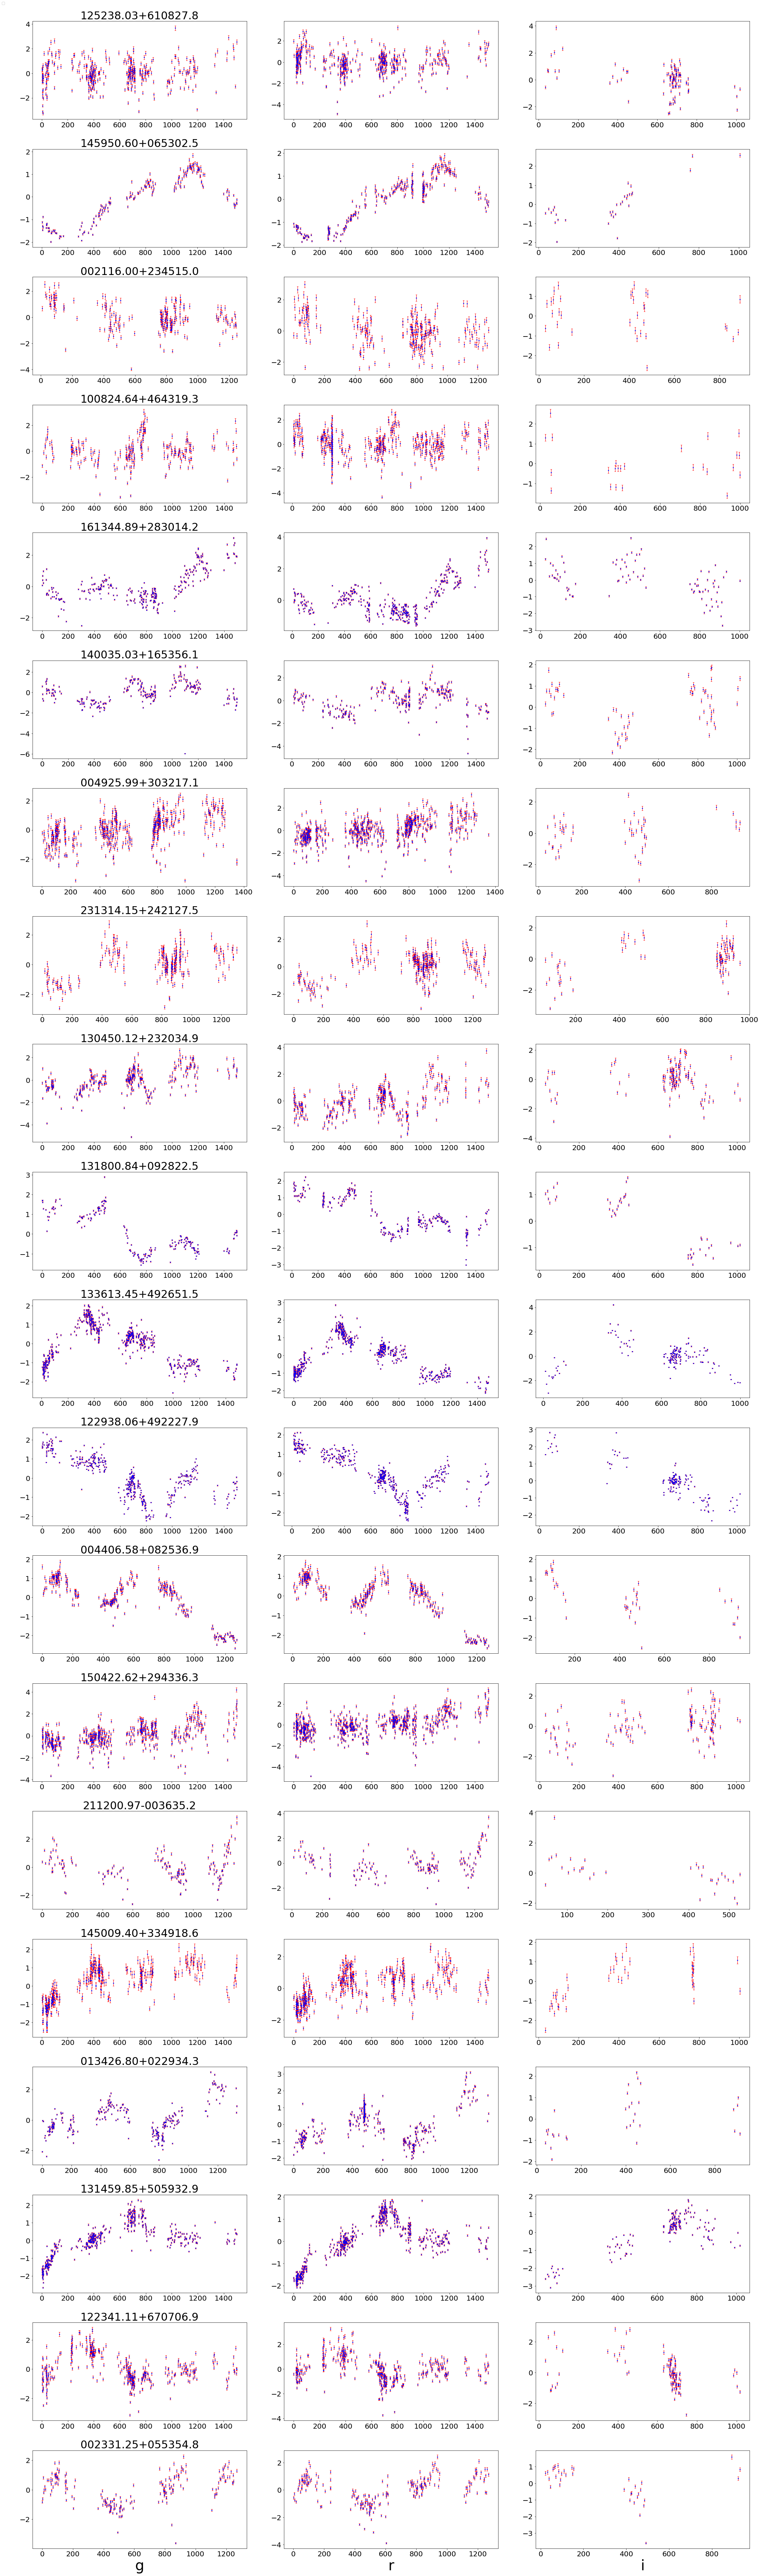

In [364]:
utils.preview_lcs(lcs, g, figsize=[30,100])

In [358]:
g = np.where(scores < -0.465)[0]
len(g)

20

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  1.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  2.,  1.,  3.,
         2.,  3.,  3.,  4.,  3.,  3., 10.,  7.,  1.,  4.,  6., 12., 10.,
        16., 13., 11., 17., 17., 19., 32., 32., 34., 39., 51., 51., 56.,
        67., 58., 73., 84., 75., 63., 67., 69., 72., 49., 47., 31., 29.,
        24., 22., 10., 13.,  3.,  6.,  0.,  2.,  1.]),
 array([-0.49167163, -0.49067163, -0.48967163, -0.48867163, -0.48767163,
        -0.48667163, -0.48567163, -0.48467163, -0.48367163, -0.48267163,
        -0.48167163, -0.48067163, -0.47967163, -0.47867163, -0.47767163,
        -0.47667163, -0.47567163, -0.47467163, -0.47367163, -0.47267163,
        -0.47167163, -0.47067163, -0.46967163, -0.46867163, -0.46767163,
        -0.46667163, -0.46567163, -0.46467163, -0.46367163, -0.46267163,
        -0.46167163, -0.46067163, -0.45967163, -0.45867163, -0.45767163,
        -0.45667163, -0.45567163, -0.45467163, -0.45367163, -0.452671

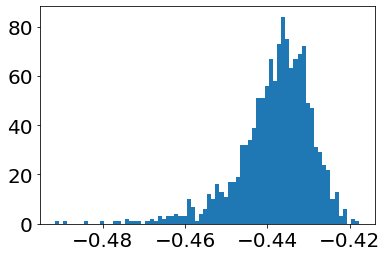

In [163]:
plt.hist(scores[new_is],bins=np.arange(np.min(scores),np.max(scores),0.001))

In [19]:
scores.shape

(1527,)

In [38]:
%autoreload

In [ ]:
[411][135, 519, 840][722]

In [212]:
np.intersect1d(bin7,[135,519,411,722,840])

array([411])

In [68]:
lcs_mis = utils.get_data('../../datasets/ZTF_gri',min_length=0, keep_missing=True)

found 3407 for band='r'
found 3407 for band='i'
found 3408 for band='g'


/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/dataset.py:167: RuntimeWarning: divide by zero encountered in true_divide
  lc[:,2] = lc[:,2] / np.std(lc[:,1])


max time:  1687.1758
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(3177, 3, 4396, 3)
train size: 2859, valid size: 572, test size: 318


In [ ]:
[135,519,411,722,840]


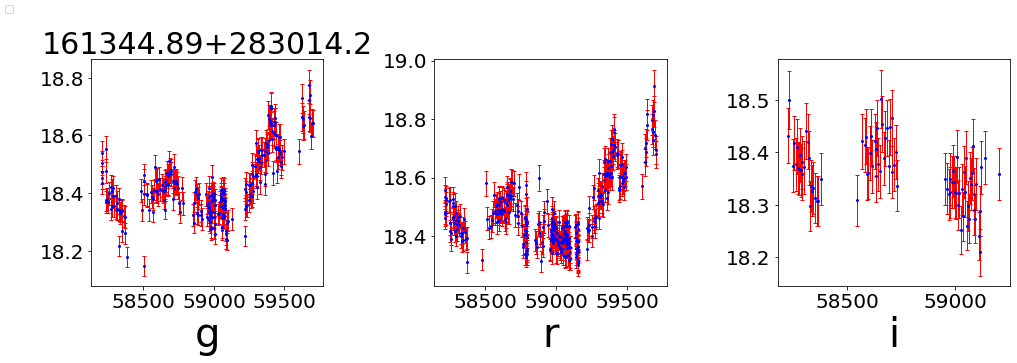

In [217]:
utils.preview_lcs(lcs_prev, [411], figsize=[15,5])

In [ ]:
scores[np.union]

In [ ]:
get all other indexes not including those with those scores 

In [161]:
new_is = np.setdiff1d(np.arange(1527),np.union1d(bin0,bin1))

In [ ]:
lcs.valid_files_df.indexes

In [173]:
x = np.where(scores[new_is] <= -0.449)[0]
len(x)

139

In [218]:
np.intersect1d(new_is,[411])

array([411])

In [257]:
x = np.where(scores[new_is] <= -0.4649)[0]
x

array([ 65, 119, 261, 334, 343, 356, 359, 381, 407, 450, 455, 524, 624,
       666, 726, 748, 757, 809, 888, 973])

In [249]:
scores[new_is][x]

array([-0.46895718, -0.46819086, -0.46655857, -0.4843061 , -0.46499338,
       -0.4718819 , -0.47412419, -0.47977284, -0.46574474, -0.46850562,
       -0.46603769, -0.46727577, -0.47409159, -0.49167163, -0.47138885,
       -0.47638662, -0.4651413 , -0.48960321, -0.47328347, -0.47759497])

In [253]:
lcs_prev.dataset = lcs_prev.dataset[new_is]

In [279]:
np.where(lcs.valid_files_df.index=='002116.00+234515.0')

(array([293]),)

In [255]:
lcs_prev.dataset.shape

(1341, 3, 4396, 3)

In [277]:
lcs_prev.valid_files_df = lcs_prev.valid_files_df.iloc[new_is]

In [284]:
lcs_prev.valid_files_df.index[x]

Index(['125238.03+610827.8', '145950.60+065302.5', '002116.00+234515.0',
       '100824.64+464319.3', '003542.60+302321.9', '161344.89+283014.2',
       '140035.03+165356.1', '004925.99+303217.1', '130450.12+232034.9',
       '131800.84+092822.5', '133613.45+492651.5', '122938.06+492227.9',
       '004406.58+082536.9', '150422.62+294336.3', '211200.97-003635.2',
       '145009.40+334918.6', '013426.80+022934.3', '131459.85+505932.9',
       '122341.11+670706.9', '002331.25+055354.8'],
      dtype='object')

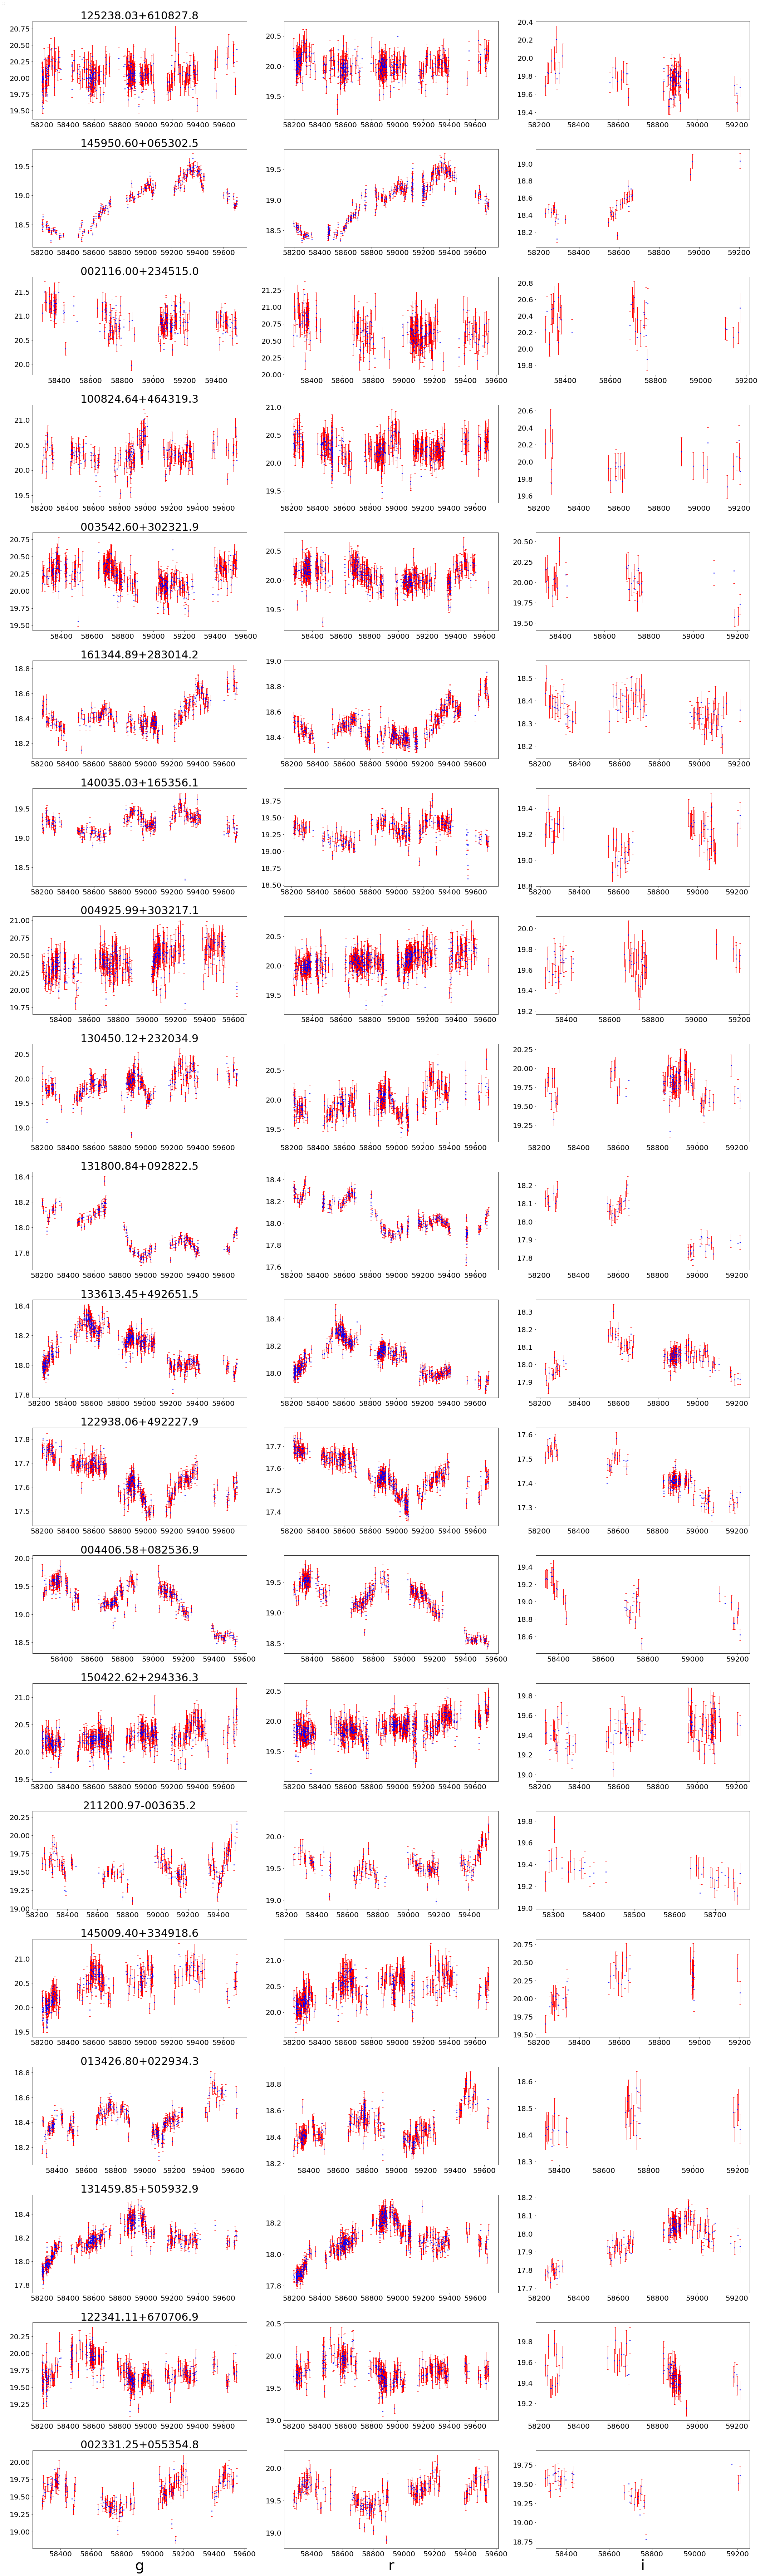

In [278]:
utils.preview_lcs(lcs_prev, x, figsize=[30,100])

In [115]:


$161344.89+283014.2$, $004406.58+082536.9$ and $211200.97-003635.2$. 


array([ 384,  411,  415,  438,  458,  722,  770,  840,  867,  932, 1028,
       1124])

In [136]:
lcs_prev.dataset[x,:,:,2].mean(-1).mean(-1)

array([0.01019211, 0.00217113, 0.00683249, 0.00946876, 0.00235427,
       0.00337618, 0.01223874, 0.00761792, 0.00733269, 0.00121578,
       0.00315868, 0.00190163, 0.00402707, 0.01283497, 0.00223746,
       0.01024504, 0.00234499, 0.00343106, 0.00744072, 0.00338202],
      dtype=float32)

In [ ]:
# which were removed from the top twnety?

In [294]:
x = np.where(scores <= -0.465)[0]
len(x)

20

In [295]:
lcs.valid_files_df.index[x]

Index(['125238.03+610827.8', '145950.60+065302.5', '002116.00+234515.0',
       '100824.64+464319.3', '161344.89+283014.2', '140035.03+165356.1',
       '004925.99+303217.1', '231314.15+242127.5', '130450.12+232034.9',
       '131800.84+092822.5', '133613.45+492651.5', '122938.06+492227.9',
       '004406.58+082536.9', '150422.62+294336.3', '211200.97-003635.2',
       '145009.40+334918.6', '013426.80+022934.3', '131459.85+505932.9',
       '122341.11+670706.9', '002331.25+055354.8'],
      dtype='object')

In [296]:
old = ['125238.03+610827.8', '145950.60+065302.5', '002116.00+234515.0',
       '100824.64+464319.3', '161344.89+283014.2', '140035.03+165356.1',
       '004925.99+303217.1', '231314.15+242127.5', '130450.12+232034.9',
       '131800.84+092822.5', '133613.45+492651.5', '122938.06+492227.9',
       '004406.58+082536.9', '150422.62+294336.3', '211200.97-003635.2',
       '145009.40+334918.6', '013426.80+022934.3', '131459.85+505932.9',
       '122341.11+670706.9', '002331.25+055354.8']

# versus new

new = ['125238.03+610827.8', '145950.60+065302.5', '002116.00+234515.0',
       '100824.64+464319.3', '003542.60+302321.9', '161344.89+283014.2',
       '140035.03+165356.1', '004925.99+303217.1', '130450.12+232034.9',
       '131800.84+092822.5', '133613.45+492651.5', '122938.06+492227.9',
       '004406.58+082536.9', '150422.62+294336.3', '211200.97-003635.2',
       '145009.40+334918.6', '013426.80+022934.3', '131459.85+505932.9',
       '122341.11+670706.9', '002331.25+055354.8']


np.setdiff1d(old,new)


array(['231314.15+242127.5'], dtype='<U18')

In [303]:
np.setdiff1d(new,old)

array(['003542.60+302321.9'], dtype='<U18')

In [297]:
np.where(lcs.valid_files_df.index=='231314.15+242127.5')

(array([458]),)

In [304]:
np.where(lcs.valid_files_df.index=='003542.60+302321.9')

(array([395]),)

In [335]:
%autoreload
lcs._re

In [339]:
np.where(lcs_prex.sigma_nxs.mean(-1) > 0.2)

(array([   0,    1,    2, ..., 1524, 1525, 1526]),)

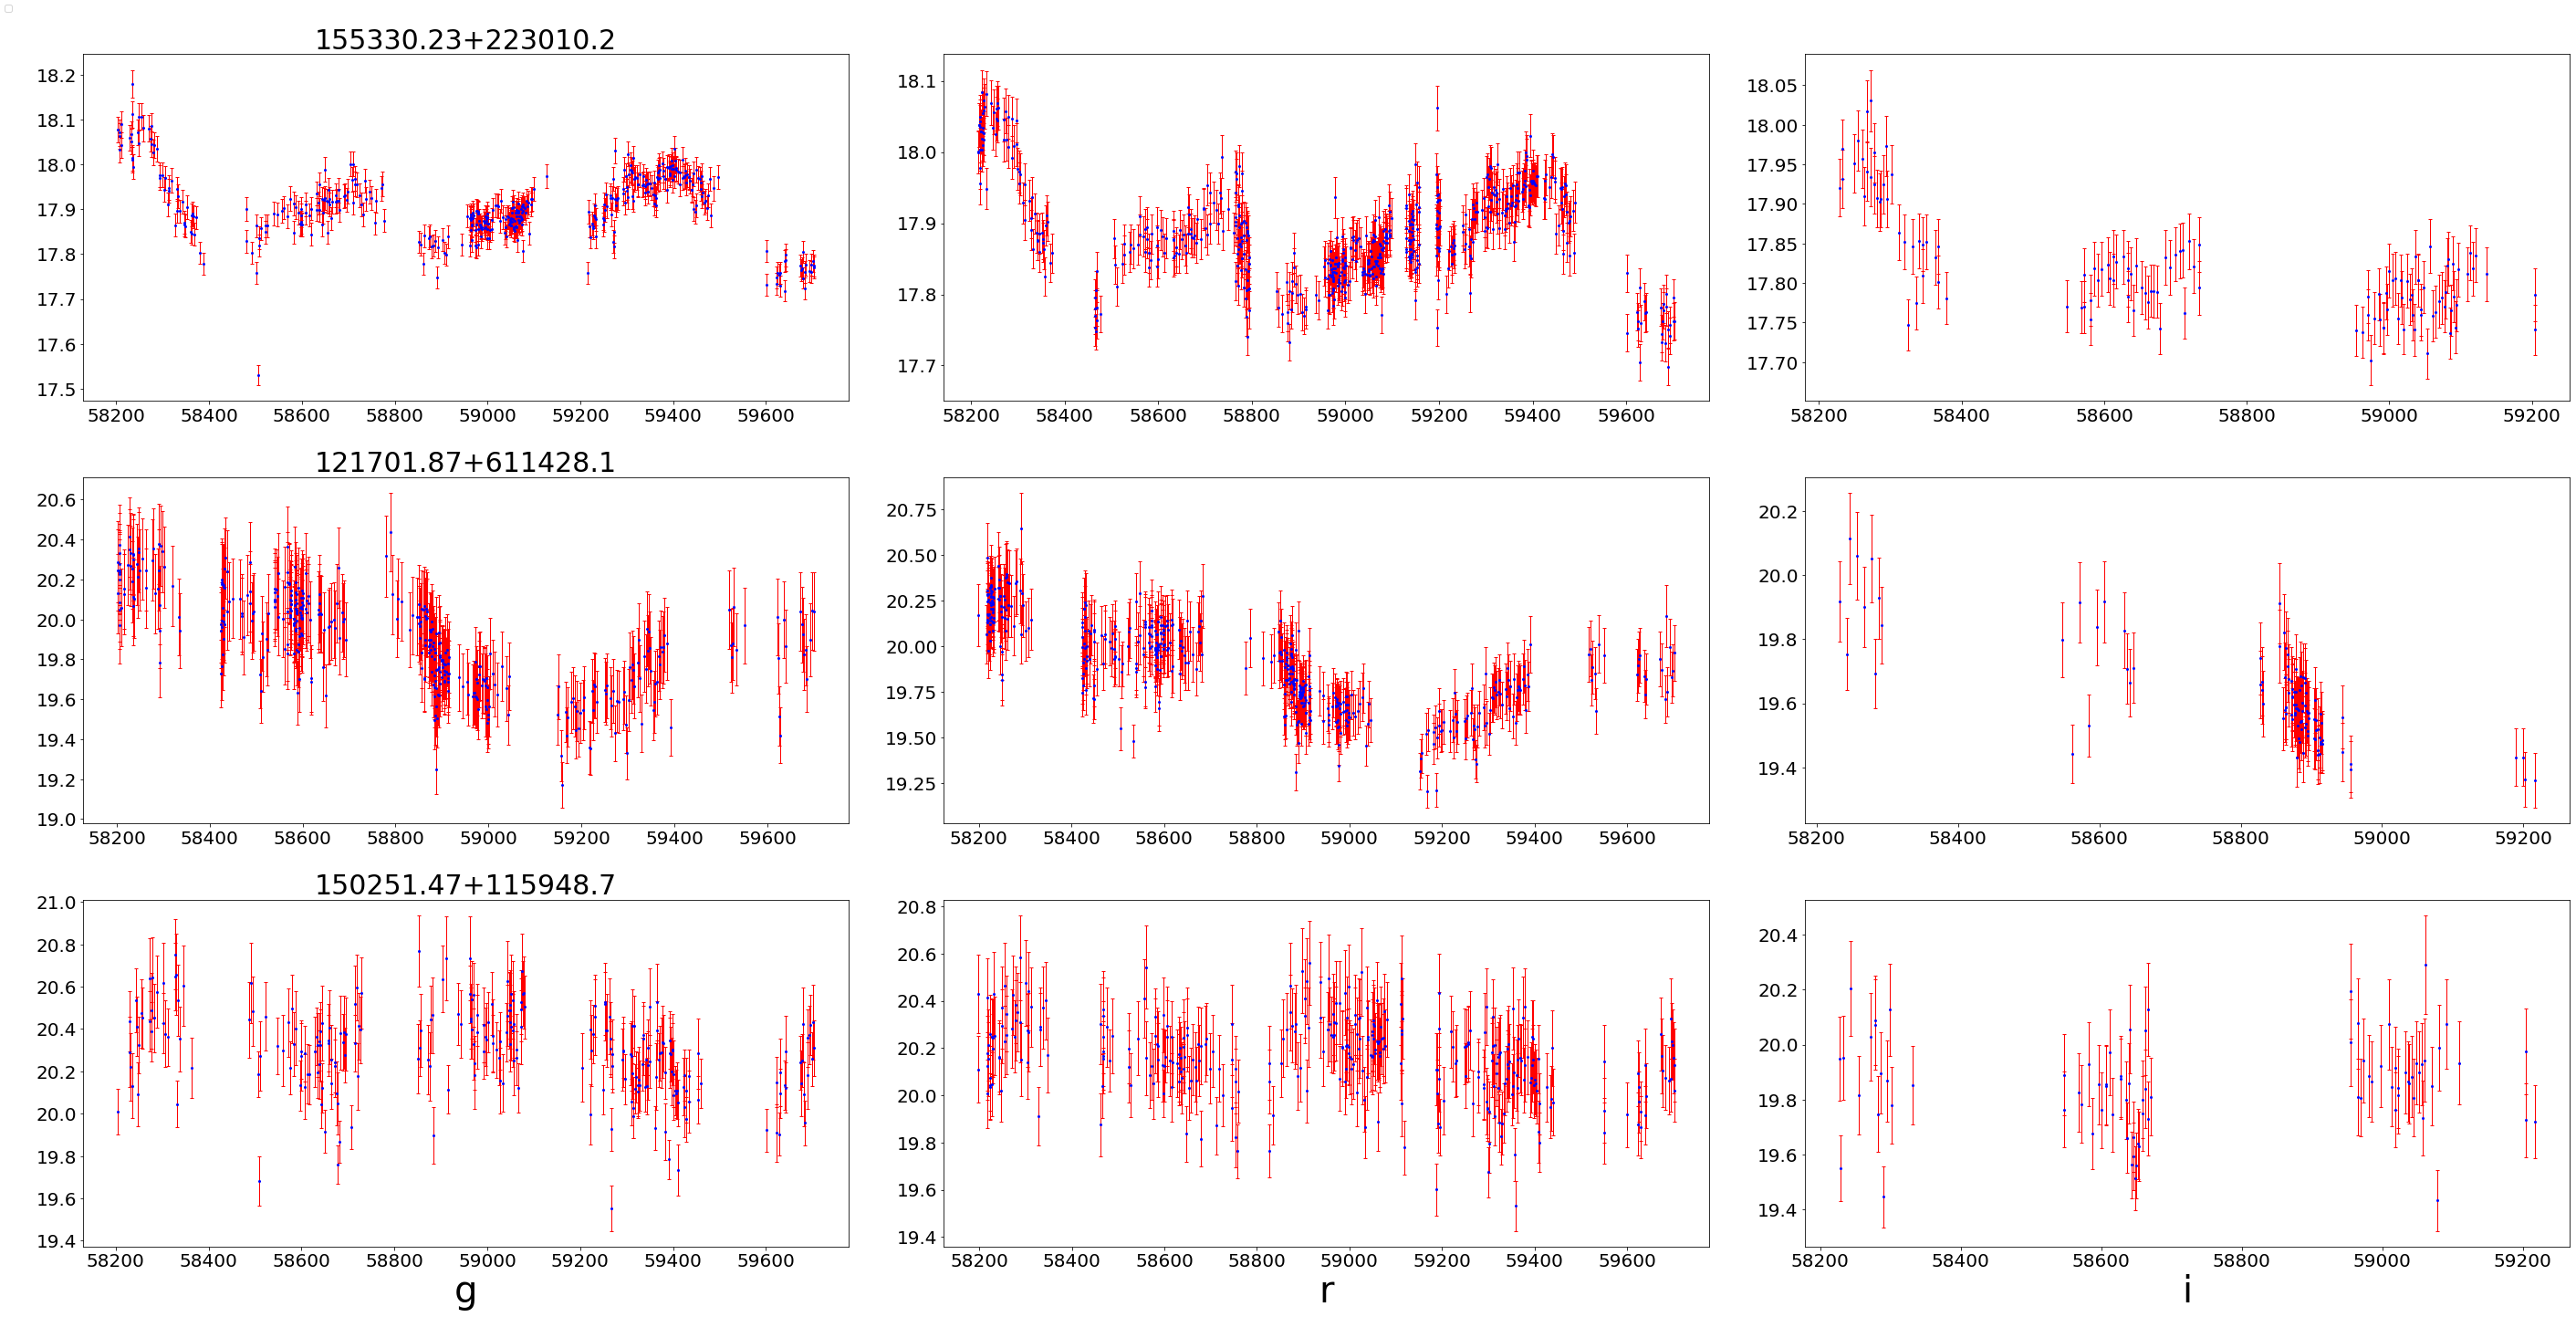

In [341]:
utils.preview_lcs(lcs_prex,[ 576, 1002, 1502], figsize=[40,20])

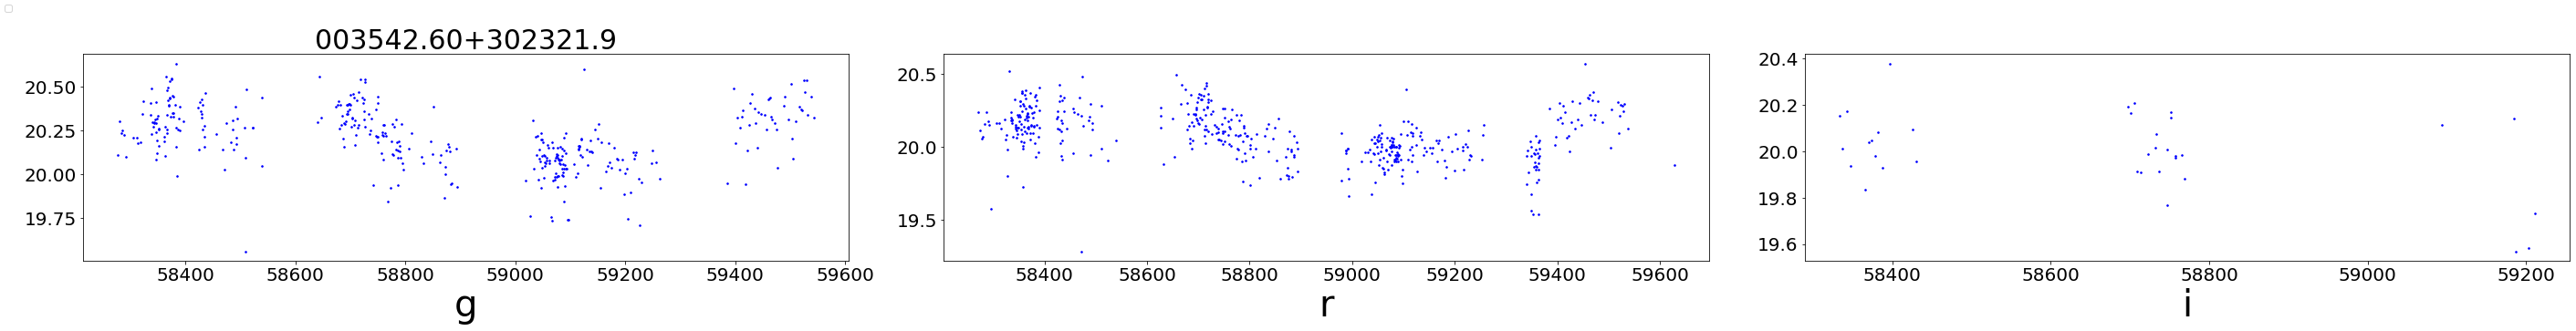

In [327]:
utils.preview_lcs(lcs_prex,[395], figsize=[40,5])

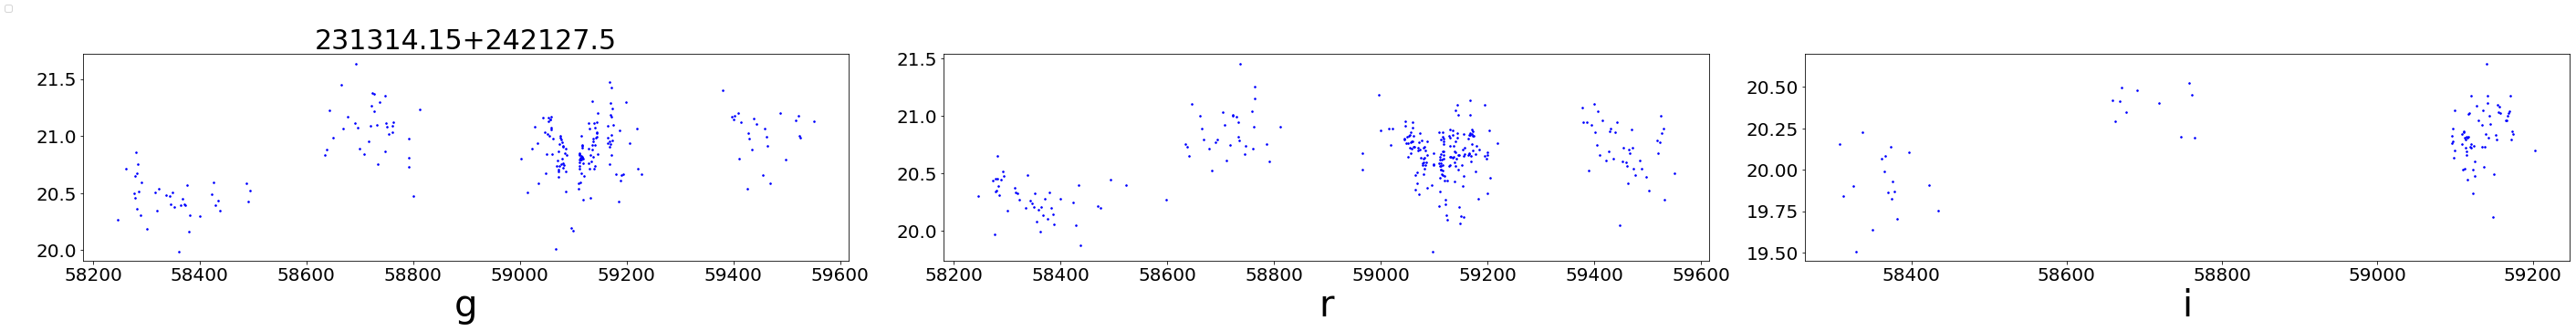

In [328]:
utils.preview_lcs(lcs_prex,[458], figsize=[40,5])

In [306]:
lcs_prex = utils.get_data('../../datasets/ZTF_gri',min_length=25, keep_missing=False,norm=False)


found 3408 for band='r'
found 3408 for band='i'
found 3408 for band='g'
max time:  59889.55
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(1527, 3, 4396, 3)
train size: 1374, valid size: 275, test size: 153


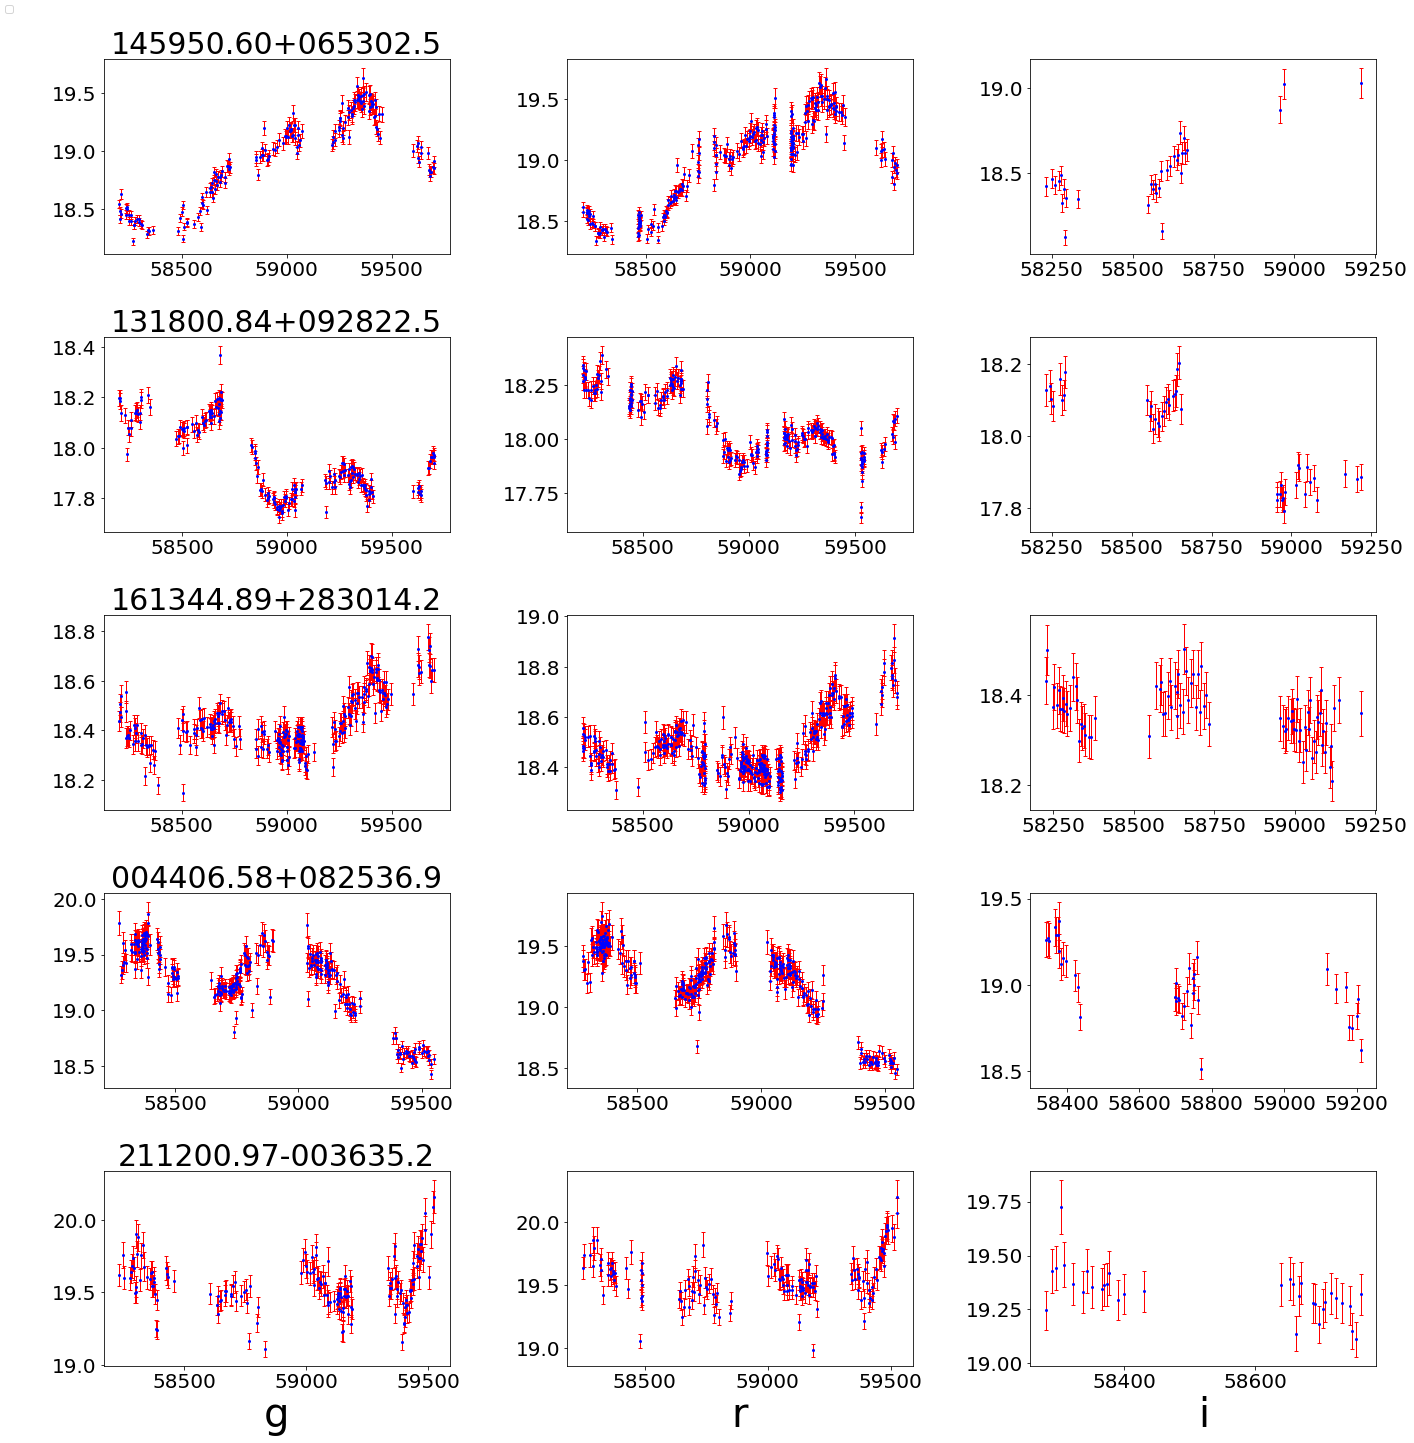

In [190]:
utils.preview_lcs(lcs_prev, [135,519,411,722,840],figsize=[20,20])

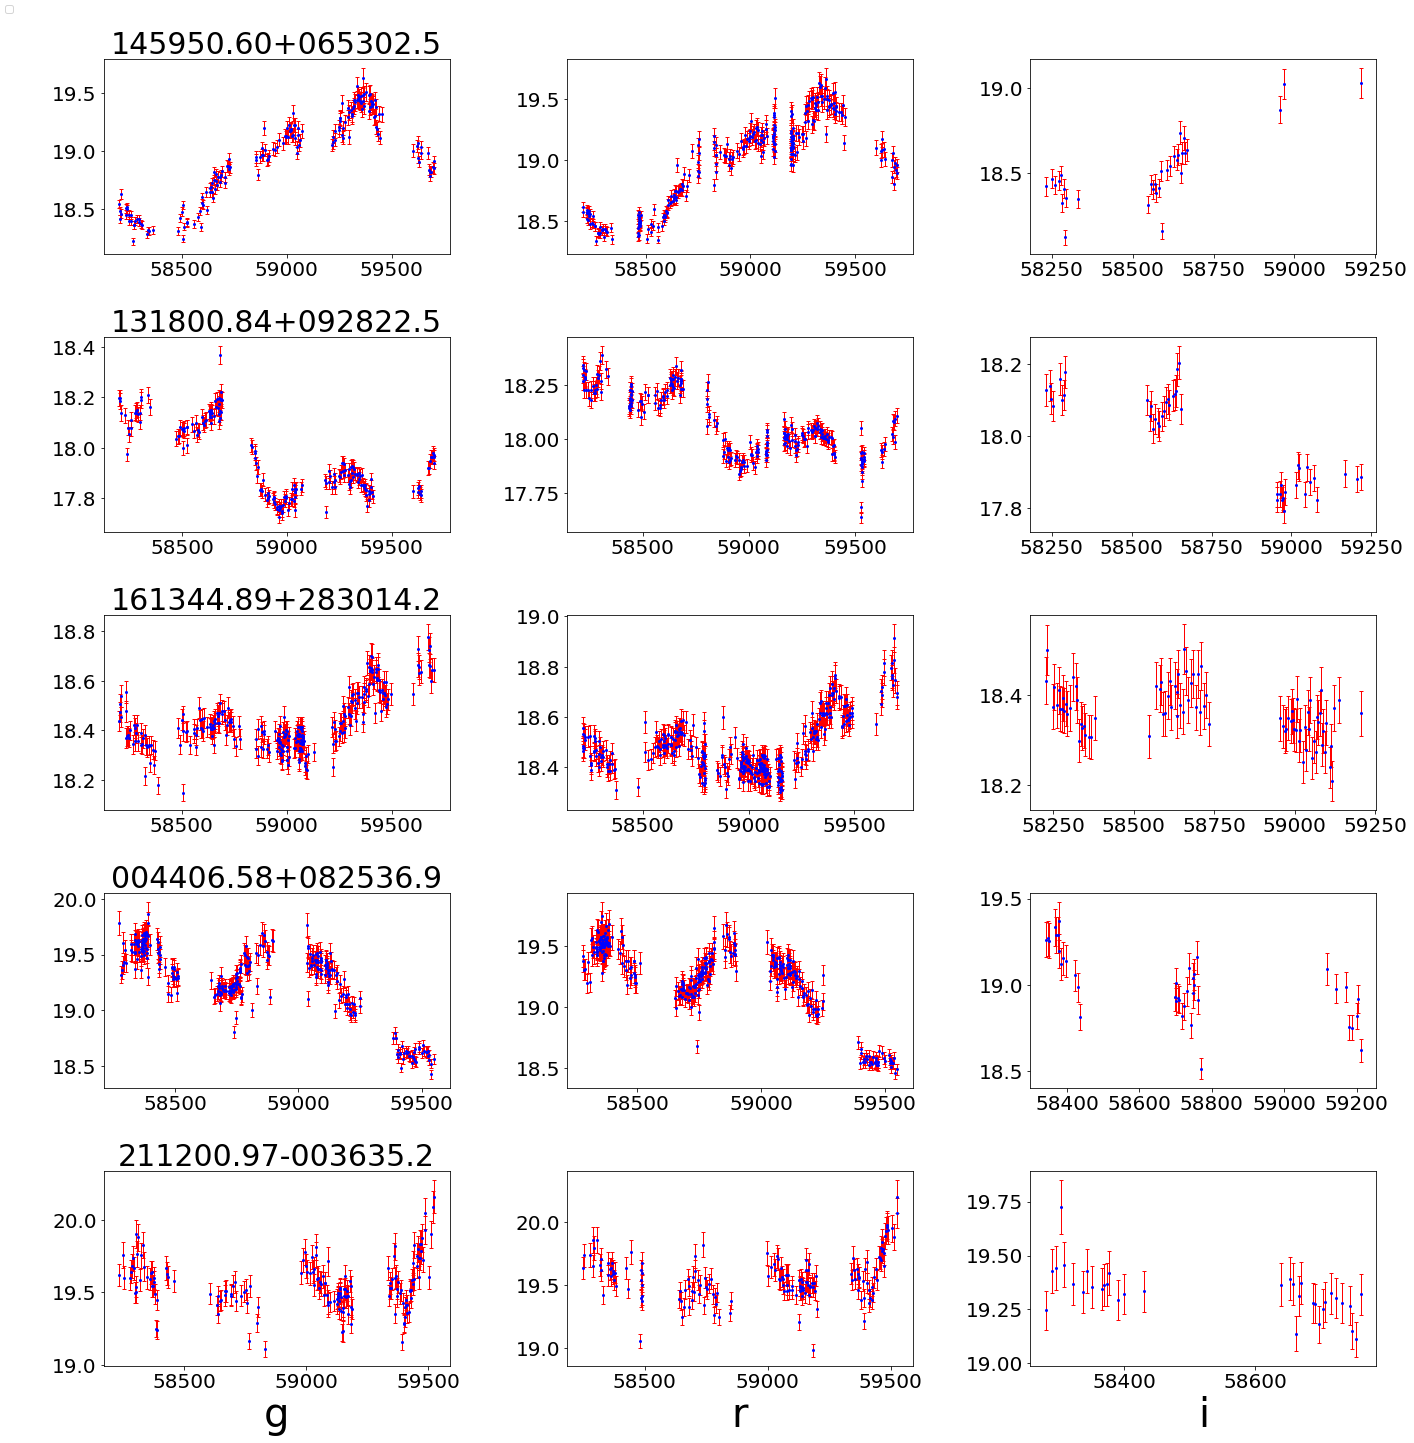

In [120]:
utils.preview_lcs(lcs_prev,x, figsize=[20,20],save=True,filepath='../img/anomaly_d/5anoms')

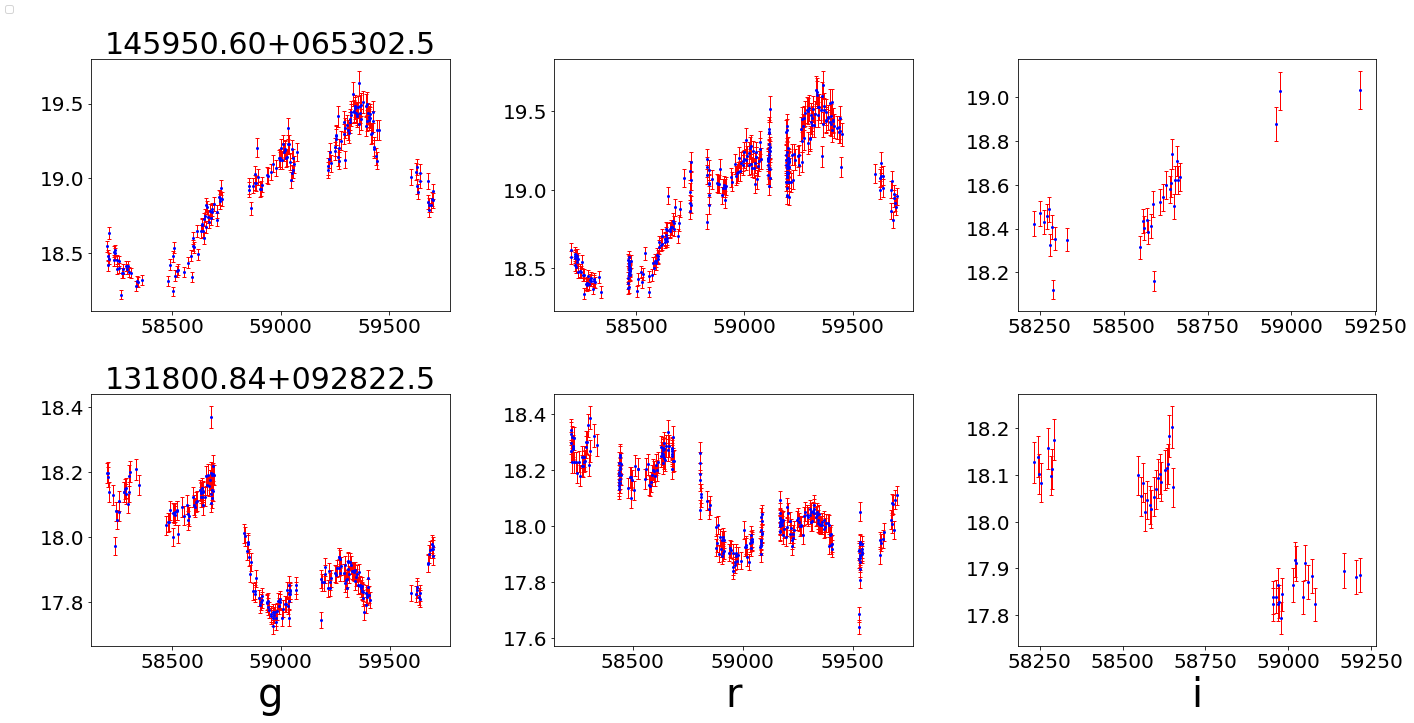

In [98]:
# utils.preview_lcs(lcs_prev,x,figsize=[20,15])
utils.preview_lcs(lcs_prev, [135,519],figsize=[20,10],save=True,filepath='../img/anomaly_d/2anoms')
# utils.preview_lcs(lcs_prev, [411,  722, 840],figsize=[20,15],save=True,filepath='../img/anomaly_d/3anoms')

## Get normalized excess variance from dataset

In [25]:
np.random.seed(2) ## keep same shuffled as was trained on 
torch.manual_seed(2)

folder = '../../datasets/ZTF_g'

lcs = DataSet(name=folder)
[lcs.add_band(os.path.join(folder, band_folder)) for band_folder in os.listdir(folder)]
lcs.filter()  
lcs.prune_outliers()  
lcs.set_mean_mag()
lcs.set_sigma_nxs()
lcs.set_med_cadence()


validated 3408 files out of 3408 for band='g'


In [26]:
shuffle = np.random.permutation(len(lcs.dataset)) # shuffle so these labels and dataset encodings are aligned 
lcs.sigma_nxs = lcs.sigma_nxs[shuffle]

(array([3.200e+01, 2.177e+03, 2.640e+02, 5.700e+01, 1.800e+01, 5.000e+00,
        1.000e+00, 0.000e+00]),
 array([-0.0001,  0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,
         0.0006,  0.0007]),
 <BarContainer object of 8 artists>)

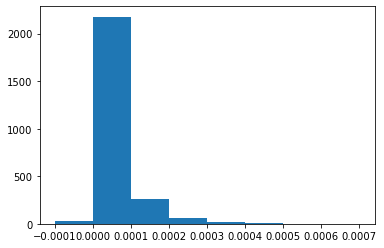

In [27]:
plt.hist(lcs.sigma_nxs, bins=np.arange(-0.0001,0.0008,0.0001))

In [ ]:
## save dataset before its formatted for this reason... 

## Tachibana MLP 

##### labels: lcs.sigma_nxs
##### dataset: zs

In [113]:
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, INPUT_DIM):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(INPUT_DIM, 32),
          nn.ReLU(),
          nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [121]:
lcs.sigma_nxs.mean()

5.524374240692364e-05

In [122]:
labels = (lcs.sigma_nxs).astype(np.float32)
data = zs.reshape(zs.shape[0], -1).astype(np.float32)
dataset = [(data[i],labels[i]) for i in range(len(data))]
dl = DataLoader(dataset, batch_size=2)

In [124]:
labels.mean()

5.5243745e-05

In [125]:
def my_loss(pred, target):
    loss = ((target - pred)**2) /(target - 5.5243745e-05)**2
    return loss.sum()


In [126]:
device = torch.device('mps')
INPUT_DIM = 1024
model = MLP(INPUT_DIM)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = my_loss#nn.MSELoss()

In [127]:
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [128]:
losses = []

In [131]:
EPOCHS = 1000

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0
    model.train()
    for (x,y) in dl:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(x)
    losses.append(epoch_loss)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:02:36<00:00,  3.76s/it]


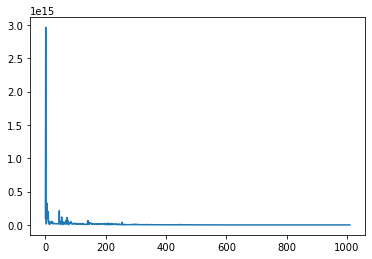

In [132]:
plt.plot(losses)

In [ ]:
## choose anomalies based on validation / test set 

In [ ]:
#zero out each value, see output of the model... see which outputs are highest 

In [93]:
#sklearn train-test split
# zero ou


In [ ]:

one_hot = np.identity(1024) 
ic = np.zeros((len(data),1024))
for i in tqdm(range(len(data))): # for all examples in dataset
    for j in range(1024): # for all indexes of latent vector
        with torch.no_grad():
            inpt = torch.tensor(data[i] * one_hot[j], dtype=torch.float)#zero out all but one i from latent vec
            inpt = inpt.to(device)
            out = model(inpt).item()
            ic[i,j] = 1 - my_loss(out, labels[i]) # compute r^2
                   

 44%|█████████████████████████████████████████████████████████████████▊                                                                                   | 1131/2559 [4:53:30<2:45:19,  6.95s/it]